# Imports

In [1]:
from pathlib import Path
import numpy as np
import jax.numpy as jnp
import pandas as pd
import jax
import jraph
import matplotlib.pyplot as plt

import flax.linen as nn
import optax
from tqdm import trange

from typing import Sequence, Callable, Dict

# Load data

In [2]:
data_dir = Path('/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-data/val_split/')
# you can find a train/test/val split of the data in the data directory

In [3]:
train_halos = jnp.load(data_dir / 'train_halos.npy')
test_halos = jnp.load(data_dir / 'test_halos.npy')

train_cosmology = pd.read_csv(data_dir / 'train_cosmology.csv')
test_cosmology = pd.read_csv(data_dir / 'test_cosmology.csv')

train_omega_m = jnp.array(train_cosmology['Omega_m'].values)[:,None]
test_omega_m = jnp.array(test_cosmology['Omega_m'].values)[:,None]

train_masses = jnp.log10(train_halos[...,[-1]])
test_masses = jnp.log10(train_halos[...,[-1]])

train_velocities = jnp.sum(train_halos[...,3:6]**2, axis=-1)
test_velocities = jnp.sum(train_halos[...,3:6]**2, axis=-1)

train_halo_pos = train_halos[...,:3] / 1000. # let's divide by the boxsize so they are all between 0 and 1
test_halo_pos = test_halos[...,:3] / 1000.

2023-11-27 16:44:50.421772: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [23]:
print(train_halos.shape, test_halos.shape)

(1600, 5000, 7) (200, 5000, 7)


In [6]:
print(train_velocities.shape)

(1600, 5000)


In [98]:
train_cosmology.head()

,Omega_m,Omega_b,h,n_s,sigma_8
0,0.1755,0.06681,0.7737,0.8849,0.6641
1,0.2139,0.05557,0.8599,0.9785,0.8619
2,0.1867,0.04503,0.6189,0.8307,0.7187
3,0.3271,0.06875,0.6313,0.8135,0.8939
4,0.1433,0.06347,0.6127,1.1501,0.7699


# Building the graph

## K-nearest neighbors

In [5]:
from functools import partial

EPS = 1e-5

def apply_pbc(dr: np.array, cell: np.array) -> np.array:
    """Apply periodic boundary conditions to a displacement vector, dr, given a cell.

    Args:
        dr (np.array): An array of shape (N,3) containing the displacement vector
        cell_matrix (np.array): A 3x3 matrix describing the box dimensions and orientation.

    Returns:
        np.array: displacement vector with periodic boundary conditions applied
    """
    return dr - jnp.round(dr.dot(jnp.linalg.inv(cell))).dot(cell)

@partial(jax.jit, static_argnums=(1, 3))
def nearest_neighbors(
    x: np.array,
    k: int,
    cell: np.array = None,
    pbc: bool = False,
):
    """Returns the nearest neighbors of each node in x.

    Args:
        x (np.array): positions of nodes
        k (int): number of nearest neighbors to find
        mask (np.array, optional): node mask. Defaults to None.

    Returns:
        sources, targets: pairs of neighbors
    """
    n_nodes = x.shape[0]
    # Compute the vector difference between positions
    dr = (x[:, None, :] - x[None, :, :]) + EPS
    if pbc:
        dr = apply_pbc(
            dr=dr,
            cell=cell,
        )

    # Calculate the distance matrix
    distance_matrix = np.sum(dr**2, axis=-1)

    # Get indices of nearest neighbors
    indices = np.argsort(distance_matrix, axis=-1)[:, :k]

    # Create sources and targets arrays
    sources = np.repeat(np.arange(n_nodes), k)
    targets = indices.ravel()
    
    # return sources, targets, distance_matrix[sources, targets]
    return sources, targets, dr[sources, targets]

In [6]:
cell = jnp.array([[1.,0.,0.,],[0.,1.,0.], [0.,0.,1.]])

def build_graph(halo_pos, k, use_pbc=True, use_edges=True,):

    n_batch = len(halo_pos)
    sources, targets, distances = jax.vmap(partial(nearest_neighbors, pbc=use_pbc), in_axes=(0, None, None))(halo_pos, k, cell)

    return jraph.GraphsTuple(
            n_node=jnp.array([[halo_pos.shape[1]]]*n_batch),
            n_edge=jnp.array(n_batch * [[k]]),
            nodes=halo_pos, # node features
            edges=jnp.sqrt(jnp.sum(distances **2, axis=-1, keepdims=True)) if use_edges else None, # edge features
            globals=None,
            senders=sources,
            receivers=targets,
        )

### Check correlation between mass and average neighbor distance

In [25]:
k = 10
use_pbc = True

Only use a batch of 10 simulations due to memory issues

In [26]:
sources, targets, distances = jax.vmap(partial(nearest_neighbors, pbc=use_pbc), 
                                       in_axes=(0, None, None))(train_halo_pos[:1], k, cell)

In [27]:
dists = jnp.sqrt(jnp.sum(distances **2, axis=-1, keepdims=True))
dists = dists.reshape((-1, 5000, 10))
avg_neighbor_dists = jnp.mean(dists, axis=-1, keepdims=True)

In [28]:
jnp.corrcoef(train_masses[:1].squeeze(), avg_neighbor_dists.squeeze())

Array([[ 1.        , -0.15840591],
       [-0.15840591,  1.        ]], dtype=float32)

Text(0.5, 1.0, 'Average neighbor distance (Mpc/h) vs. log(Mass)')

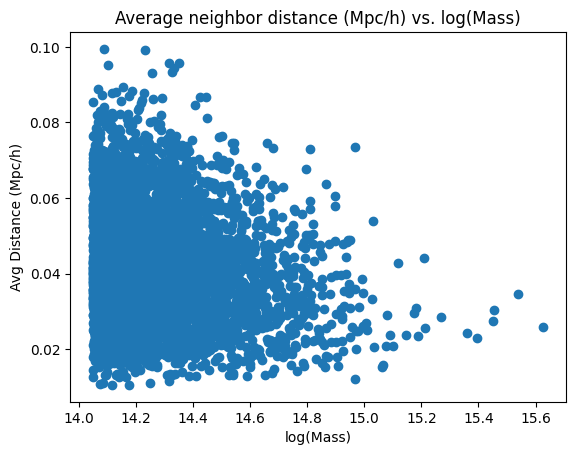

In [29]:
plt.scatter(train_masses[:1].squeeze(), avg_neighbor_dists.squeeze())
plt.xlabel('log(Mass)')
plt.ylabel('Avg Distance (Mpc/h)')
plt.title('Average neighbor distance (Mpc/h) vs. log(Mass)')

Very low negative correlation. Let's try increasing k

In [21]:
k = 200
sources, targets, distances = jax.vmap(partial(nearest_neighbors, pbc=use_pbc), 
                                       in_axes=(0, None, None))(train_halo_pos[:1], k, cell)
dists = jnp.sqrt(jnp.sum(distances **2, axis=-1, keepdims=True))
dists = dists.reshape((-1, 5000, k))
avg_neighbor_dists = jnp.mean(dists, axis=-1, keepdims=True)

jnp.corrcoef(train_masses[:1].squeeze(), avg_neighbor_dists.squeeze())

Array([[ 1.        , -0.05196658],
       [-0.05196658,  0.99999994]], dtype=float32)

Text(0.5, 1.0, 'Average neighbor distance (Mpc/h) vs. log(Mass)')

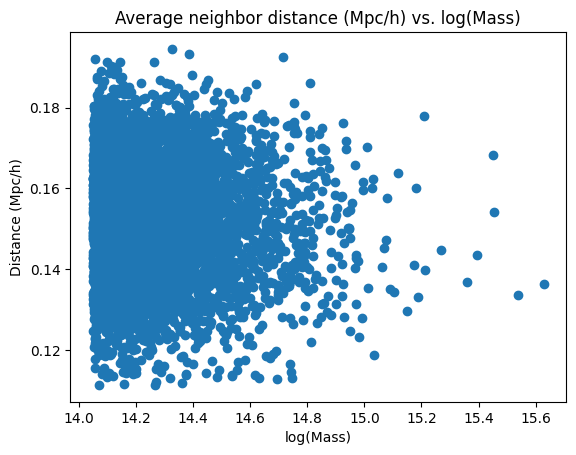

In [22]:
plt.scatter(train_masses[:1].squeeze(), avg_neighbor_dists.squeeze())
plt.xlabel('log(Mass)')
plt.ylabel('Avg Distance (Mpc/h)')
plt.title('Average neighbor distance (Mpc/h) vs. log(Mass)')

Increasing k makes it worse.

Dynamical range:

In [20]:
print(dists.min(), dists.max())
print(dists.mean())

1.7320506e-05 0.11554166
0.026856298


How about correlation with velocity?

In [32]:
k = 10
sources, targets, distances = jax.vmap(partial(nearest_neighbors, pbc=use_pbc), 
                                       in_axes=(0, None, None))(train_halo_pos[:1], k, cell)
dists = jnp.sqrt(jnp.sum(distances **2, axis=-1, keepdims=True))
dists = dists.reshape((-1, 5000, k))
avg_neighbor_dists = jnp.mean(dists, axis=-1, keepdims=True)

jnp.corrcoef(train_velocities[:1].squeeze(), avg_neighbor_dists.squeeze())

Array([[ 1.       , -0.2768809],
       [-0.2768809,  1.       ]], dtype=float32)

Text(0.5, 1.0, 'Average neighbor distance (Mpc/h) vs. Velocity')

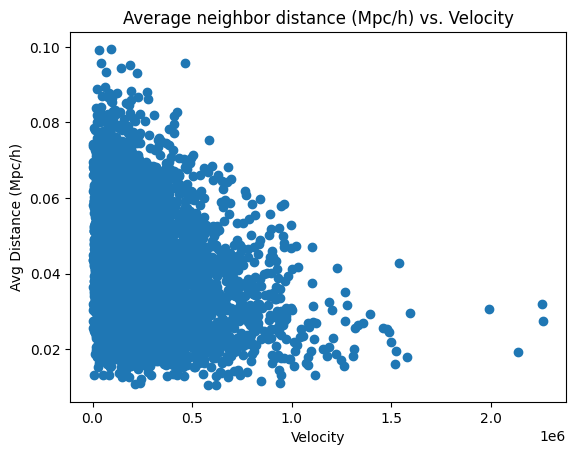

In [33]:
plt.scatter(train_velocities[:1].squeeze(), avg_neighbor_dists.squeeze())
plt.xlabel('Velocity')
plt.ylabel('Avg Distance (Mpc/h)')
plt.title('Average neighbor distance (Mpc/h) vs. Velocity')

## Radial cutoff

In [34]:
from functools import partial

EPS = 1e-5

def apply_pbc(dr: np.array, cell: np.array) -> np.array:
    """Apply periodic boundary conditions to a displacement vector, dr, given a cell.

    Args:
        dr (np.array): An array of shape (N,3) containing the displacement vector
        cell_matrix (np.array): A 3x3 matrix describing the box dimensions and orientation.

    Returns:
        np.array: displacement vector with periodic boundary conditions applied
    """
    return dr - jnp.round(dr.dot(jnp.linalg.inv(cell))).dot(cell)

@partial(jax.jit, static_argnums=(1, 3))
def dist_r_neighbors(
    x: np.array,
    r: int,
    cell: np.array = None,
    pbc: bool = False,
):
    """Returns the nearest neighbors of each node in x.

    Args:
        x (np.array): positions of nodes
        k (int): number of nearest neighbors to find
        mask (np.array, optional): node mask. Defaults to None.

    Returns:
        sources, targets: pairs of neighbors
    """
    n_nodes = x.shape[0]
    # Compute the vector difference between positions
    dr = (x[:, None, :] - x[None, :, :]) + EPS
    if pbc:
        dr = apply_pbc(
            dr=dr,
            cell=cell,
        )

    # Calculate the distance matrix
    distance_matrix = jnp.sum(dr**2, axis=-1)

    # Get indices of nearest neighbors
    # mask = (distance_matrix <= r) & (jnp.arange(n_nodes)[:, None] < jnp.arange(n_nodes))
    mask = distance_matrix <= r
    return mask, dr, distance_matrix
 

In [18]:
cell = jnp.array([[1.,0.,0.,],[0.,1.,0.], [0.,0.,1.]])

def build_radial_graph(halo_pos, r, use_pbc=True, use_edges=True,):

    n_batch = len(halo_pos)
    mask, dr = jax.vmap(partial(nearest_neighbors, pbc=use_pbc), in_axes=(0, None, None))(halo_pos, r, cell)
    sources, targets = jnp.where(mask)
    distances = dr[sources, targets]

    return jraph.GraphsTuple(
            n_node=jnp.array([[halo_pos.shape[1]]]*n_batch),
            n_edge=jnp.array(n_batch * [[k]]),
            nodes=halo_pos, # node features
            edges=jnp.sqrt(jnp.sum(distances **2, axis=-1, keepdims=True)) if use_edges else None, # edge features
            globals=None,
            senders=sources,
            receivers=targets,
        )

### Check correlation between masses and node degree mask

In [ ]:
r = 0.001

mask, dr, distance_matrix = jax.vmap(partial(dist_r_neighbors, pbc=True), 
                                       in_axes=(0, None, None))(train_halo_pos[:1], r, cell)

print('Fraction of pairs that have edges:', np.sum(mask)/mask.flatten().size)

degrees = jnp.sum(mask, axis=2)

print('Corr(degree, mass)):', jnp.corrcoef(train_masses[:1].squeeze(), degrees))
print('Corr(degree, velocity)):', jnp.corrcoef(train_velocities[:1].squeeze(), degrees))
plt.hist(degrees)
plt.show()

Text(0.5, 1.0, 'Average degree vs. log(Mass)')

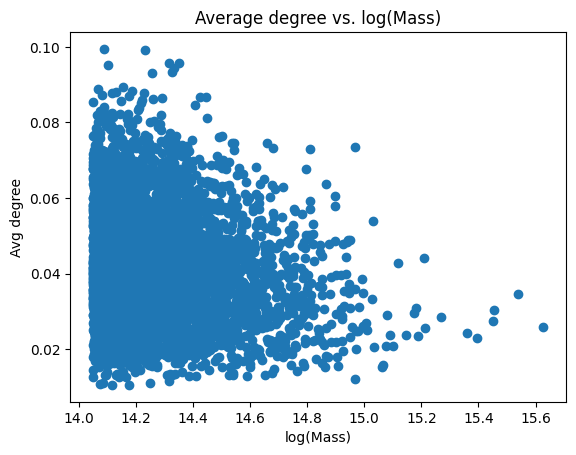

In [38]:
plt.scatter(train_masses[:1].squeeze(), avg_neighbor_dists.squeeze())
plt.xlabel('log(Mass)')
plt.ylabel('Avg degree')
plt.title('Average degree vs. log(Mass)')

Text(0.5, 1.0, 'Average degree vs. Velocity')

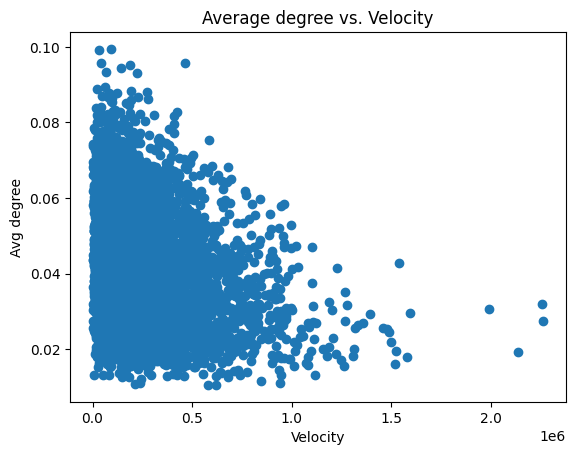

In [39]:
plt.scatter(train_velocities[:1].squeeze(), avg_neighbor_dists.squeeze())
plt.xlabel('Velocity')
plt.ylabel('Avg degree')
plt.title('Average degree vs. Velocity')

In [37]:
print(distance_matrix.min(), distance_matrix.max(), distance_matrix.mean())
print(jnp.percentile(distance_matrix, 0.25), jnp.percentile(distance_matrix, 0.5), jnp.percentile(distance_matrix, 0.75)) 

2.9999997e-10 0.7472169 0.24983312
0.0046559856 0.008703059 0.012062538


# Define Graph Network

In [7]:
class MLP(nn.Module):
    """A simple MLP."""

    feature_sizes: Sequence[int]
    activation: Callable[[np.ndarray], np.ndarray] = nn.gelu

    @nn.compact
    def __call__(self, x):
        for features in self.feature_sizes[:-1]:
            x = nn.Dense(features)(x)
            x = self.activation(x)

        # No activation on final layer
        x = nn.Dense(self.feature_sizes[-1])(x)
        return x

In [8]:
# let's build a dumb message passing GNN with jraph

def get_node_mlp_updates(mlp_feature_sizes: int, name: str = None):
    """Get a node MLP update  function

    Args:
        mlp_feature_sizes (int): number of features in the MLP
        name (str, optional): name of the update function. Defaults to None.

    Returns:
        Callable: update function
    """

    def update_fn(
        nodes: jnp.ndarray,
        sent_attributes: jnp.ndarray,
        received_attributes: jnp.ndarray,
        globals: jnp.ndarray,
    ) -> jnp.ndarray:
        """update node features

        Args:
            nodes (jnp.ndarray): node features
            sent_attributes (jnp.ndarray): attributes sent to neighbors
            received_attributes (jnp.ndarray): attributes received from neighbors
            globals (jnp.ndarray): global features

        Returns:
            jnp.ndarray: updated node features
        """
        if received_attributes is not None:
            inputs = jnp.concatenate([nodes, received_attributes], axis=1)
        else:  # If lone node
            inputs = jnp.concatenate([nodes], axis=1)
        return MLP(mlp_feature_sizes, name=name)(inputs)

    return update_fn


def get_edge_mlp_updates(mlp_feature_sizes: int, name: str = None):
    """Get an edge MLP update function

    Args:
        mlp_feature_sizes (int): number of features in the MLP
        name (str, optional): name of the update function. Defaults to None.

    Returns:
        Callable: update function
    """

    def update_fn(
        edges: jnp.ndarray,
        senders: jnp.ndarray,
        receivers: jnp.ndarray,
        globals: jnp.ndarray,
    ) -> jnp.ndarray:
        """update edge features

        Args:
            edges (jnp.ndarray): edge attributes
            senders (jnp.ndarray): senders node attributes
            receivers (jnp.ndarray): receivers node attributes
            globals (jnp.ndarray): global features

        Returns:
            jnp.ndarray: updated edge features
        """
        # If there are no edges in the initial layer
        if edges is not None:
            inputs = jnp.concatenate([edges, senders, receivers], axis=1)
        else:
            inputs = jnp.concatenate([senders, receivers], axis=1)
        return MLP(mlp_feature_sizes, name=name)(inputs)

    return update_fn

class Identity(nn.Module):
    """Module that applies the identity function, ignoring any additional args."""

    @nn.compact
    def __call__(self, x, **args):
        return x

def make_global_mlp(features):
  @jraph.concatenated_args
  def update_fn(inputs):
    return MLP(features)(inputs)
  return update_fn

class GraphNet(nn.Module):
    """A simple Graph Network"""

    latent_size: int
    hidden_size: int
    num_mlp_layers: int
    message_passing_steps: int
    skip_connections: bool = False
    norm: str = "layer"
    attention: bool = False
    in_features: int = 3
    shared_weights: bool = False  # GNN shares weights across message passing steps
    pooling: str = "mean"
    model_type: str = "gnn" #or 'deepsets'
    task: str = "graph" #or 'node'

    @nn.compact
    def __call__(self, graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
        """Do message passing on graph

        Args:
            graphs (jraph.GraphsTuple): graph object

        Returns:
            jraph.GraphsTuple: updated graph object
        """

        if graph.globals is not None:
            graph= graph._replace(globals=graph.globals.reshape(1, -1))

        mlp_feature_sizes = [self.hidden_size] * self.num_mlp_layers + [self.latent_size]
        if graph.edges is None:
            embedder = jraph.GraphMapFeatures(embed_node_fn=MLP(mlp_feature_sizes))
        else:
            embedder = jraph.GraphMapFeatures(embed_node_fn=MLP(mlp_feature_sizes), embed_edge_fn=MLP(mlp_feature_sizes))
        graph = embedder(graph)

        # Apply GCN once for each message-passing round.
        for step in range(self.message_passing_steps):
            # Initialize update functions with shared weights if specified;
            # otherwise, initialize new weights for each step
            if step == 0 or not self.shared_weights:
                suffix = "shared" if self.shared_weights else step

                update_node_fn = get_node_mlp_updates(mlp_feature_sizes, name=f"update_node_fn_{suffix}")
                update_edge_fn = get_edge_mlp_updates(mlp_feature_sizes, name=f"update_edge_fn_{suffix}")

                # Update nodes and edges; no need to update globals as they only condition
                if self.model_type == 'gnn':
                    graph_net = jraph.GraphNetwork(
                        update_node_fn=update_node_fn,
                        update_edge_fn=update_edge_fn
                    )
                else:
                    graph_net = jraph.GraphNetwork(
                        update_node_fn=update_node_fn,
                        update_edge_fn=None
                    )

            # Update graph, optionally with residual connection
            if self.skip_connections:
                new_graph = graph_net(graph)
                graph = graph._replace(
                    nodes=graph.nodes + new_graph.nodes,
                    edges=new_graph.edges,
                )
            else:
                graph = graph_net(graph)

            # Optional normalization
            if self.norm == "layer":
                norm = nn.LayerNorm()
            else:
                norm = Identity()  # No normalization

            graph = graph._replace(nodes=norm(graph.nodes), edges=norm(graph.edges))
                        
        if self.task == 'graph':
            # Aggregate nodes
            if self.pooling == 'sum':
                agg_nodes = jnp.sum(graph.nodes, axis=0)
            elif self.pooling == 'max':
                agg_nodes = jnp.max(graph.nodes, axis=0)
            else:
                agg_nodes = jnp.mean(graph.nodes, axis=0)

            # Readout prediction
            out = MLP(self.num_mlp_layers * [self.hidden_size] + [1,])(agg_nodes)
        else:
            out = MLP(self.num_mlp_layers * [self.hidden_size] + [1,])(graph.nodes) 

        return out, graph.nodes

In [9]:
class GraphWrapper(nn.Module):
    param_dict: Dict
    
    @nn.compact
    def __call__(self, x):
        model = jax.vmap(GraphNet(**self.param_dict))
        return model(x)

# Training loop

In [9]:
def run_node_expt(k, model_params, n_overfit=None, use_edges=True, n_steps=500, n_batch=10, learning_rate=1e-4, weight_decay=1e-5):
    # Initialize GNN
    model = GraphWrapper(model_params)
    # and let's intialize some parameters for it by using an example input
    key = jax.random.PRNGKey(0)
    graph = build_graph(train_halo_pos[:2], k, use_pbc=True, use_edges=use_edges)
    out, params = model.init_with_output(key, graph)
    
    @jax.jit
    def loss_fn(params, x_batch, mass_batch,):
        pred_mass = model.apply(params, x_batch)
        return jnp.mean((pred_mass - mass_batch) ** 2)  # SM: Fixed this to reflect MSE loss
    
    # Train model
    opt = optax.adamw(learning_rate=learning_rate, weight_decay=weight_decay)
    opt_state = opt.init(params)
    
    losses = []
    with trange(n_steps) as steps:
        for step in steps:
            key, subkey = jax.random.split(key)
            idx = jax.random.choice(key, train_halo_pos.shape[0], shape=(n_batch,))

            if n_overfit is not None:
                halo_batch, mass_batch = train_halo_pos[:n_overfit], train_masses[:n_overfit]  # Overfit on a small sample
                n_test = n_overfit
            else:
                halo_batch, mass_batch = train_halo_pos[idx], train_masses[idx]
                n_test = 50

            # build graph
            graph = build_graph(halo_batch, k, use_edges=use_edges)
            loss, grads = jax.value_and_grad(loss_fn)(params, graph, mass_batch)
            updates, opt_state = opt.update(grads, opt_state, params)

            params = optax.apply_updates(params, updates)

            steps.set_postfix(loss=loss)
            losses.append(loss)
    train_loss = loss
            
    # Evaluate
    if n_overfit is not None:
        graph = build_graph(train_halo_pos[:n_overfit], k, use_pbc=True, use_edges=use_edges)
        mass_pred = model.apply(params, graph)
        test_loss = jnp.mean((mass_pred - train_masses[:n_overfit]) ** 2)
    else:
        num_batches = len(test_halo_pos) // n_batch
        test_losses = []
        predictions = []
        for batch in range(num_batches):
            graph = build_graph(test_halo_pos[batch*n_batch:(batch+1)*n_batch], k, use_pbc=True, use_edges=use_edges)
            mass_pred = model.apply(params, graph)
            predictions.append(mass_pred)
            test_loss = jnp.mean((mass_pred - test_masses[batch*n_batch:(batch+1)*n_batch]) ** 2)
            test_losses.append(test_loss)
        mass_pred = jnp.concatenate(predictions)
        test_loss = sum(test_losses)/num_batches
    
    return train_loss, test_loss, mass_pred, losses
    

In [10]:
from sklearn.decomposition import PCA

In [1]:
def run_global_expt(k, model_params, n_overfit=None, use_edges=True, n_steps=500, n_batch=10, learning_rate=1e-4, weight_decay=1e-5):
    # Initialize GNN
    model = GraphWrapper(model_params)
    # and let's intialize some parameters for it by using an example input
    key = jax.random.PRNGKey(0)
    graph = build_graph(train_halo_pos[:2], k, use_pbc=True, use_edges=use_edges)
    out, params = model.init_with_output(key, graph)
    
    @jax.jit
    def loss_fn(params, x_batch, cosmo_batch,):
        pred_cosmo, embeddings = model.apply(params, x_batch)
        return jnp.mean((pred_cosmo - cosmo_batch) ** 2), embeddings  # SM: Fixed this to reflect MSE loss
    
    # Train model
    opt = optax.adamw(learning_rate=learning_rate, weight_decay=weight_decay)
    opt_state = opt.init(params)
    
    losses = []
    with trange(n_steps) as steps:
        for step in steps:
            key, subkey = jax.random.split(key)
            idx = jax.random.choice(key, train_halo_pos.shape[0], shape=(n_batch,))

            if n_overfit is not None:
                halo_batch, cosmo_batch = train_halo_pos[:n_overfit], train_omega_m[:n_overfit]  # Overfit on a small sample
                n_test = n_overfit
            else:
                halo_batch, cosmo_batch = train_halo_pos[idx], train_omega_m[idx]
                n_test = 50

            # build graph
            graph = build_graph(halo_batch, k, use_edges=use_edges)
            results, grads = jax.value_and_grad(loss_fn)(params, graph, cosmo_batch)
            loss, embeddings = results
            updates, opt_state = opt.update(grads, opt_state, params)

            params = optax.apply_updates(params, updates)

            steps.set_postfix(loss=loss)
            losses.append(loss)
    train_loss = loss
    
    pca = PCA(n_components=2)
    embeddings_PCA = pca.fit_transform(train_halo_pos[:1])
    plt.plot(embeddings_PCA[:, 0], embeddings_PCA[:, 1])
    plt.show()
            
    # Evaluate
    if n_overfit is not None:
        graph = build_graph(train_halo_pos[:n_overfit], k, use_pbc=True, use_edges=use_edges)
        omega_m_pred = model.apply(params, graph)
        test_loss = jnp.mean((omega_m_pred - train_omega_m[:n_overfit]) ** 2)
    else:
        num_batches = len(test_halo_pos) // n_batch
        test_losses = []
        predictions = []
        for batch in range(num_batches):
            graph = build_graph(test_halo_pos[batch*n_batch:(batch+1)*n_batch], k, use_pbc=True, use_edges=use_edges)
            omega_m_pred = model.apply(params, graph)
            predictions.append(omega_m_pred)
            test_loss = jnp.mean((omega_m_pred - test_omega_m[batch*n_batch:(batch+1)*n_batch]) ** 2)
            test_losses.append(test_loss)
        omega_m_pred = jnp.concatenate(predictions)
        test_loss = sum(test_losses)/num_batches
        
        node_embeddings = model.embeddings
            
    return train_loss, test_loss, omega_m_pred, losses, node_embeddings 

# Experiments

## Node-wise prediction

### DeepSets

In [47]:
k = 10
n_batch = 10

model_params = {
    'latent_size': 8, 
    'hidden_size': 64, 
    'num_mlp_layers':2, 
    'message_passing_steps':3, 
    'skip_connections': False, 
    'norm':"layer",
    'pooling':"mean",
    'model_type':"deepsets",
    'task':'node'
}


deepsets_train_loss, deepsets_test_loss, deepsets_masses_pred, deepsets_losses = run_node_expt(k, model_params, n_batch=n_batch, n_overfit=10, n_steps=150, learning_rate=1e-3)
print('Train loss: {}, Test loss: {}'.format(deepsets_train_loss, deepsets_test_loss))

100%|██████████| 150/150 [00:28<00:00,  5.22it/s, loss=0.07508958] 


Train loss: 0.07508958131074905, Test loss: 0.08398868888616562


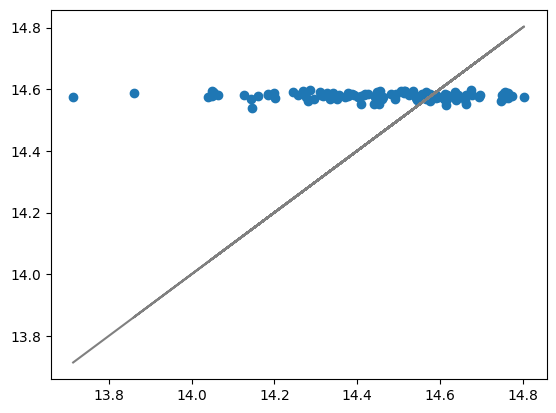

In [66]:
plt.scatter(test_masses[:100, 0, :], deepsets_masses_pred[:100, 0, :])
plt.plot(test_masses[:100, 0, :], test_masses[:100, 0, :], c='gray')

### GNN 

In [49]:
model_params['model_type'] = 'gnn'

gnn_train_loss, gnn_test_loss, gnn_masses_pred, gnn_losses = run_node_expt(k, model_params, n_batch=n_batch, n_overfit=10, n_steps=150, learning_rate=1e-3)
print('Train loss: {}, Test loss: {}'.format(gnn_train_loss, gnn_test_loss))

100%|██████████| 150/150 [00:33<00:00,  4.44it/s, loss=0.07541343] 


Train loss: 0.07541342824697495, Test loss: 0.08422549068927765


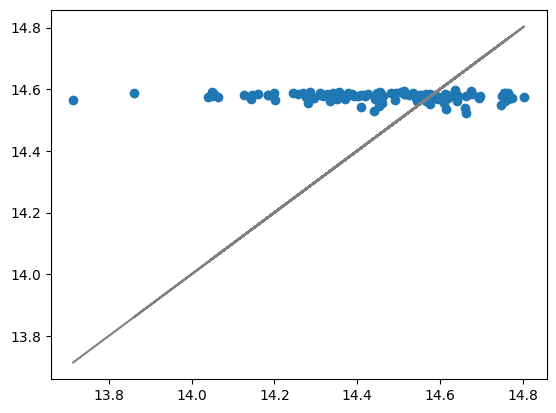

In [67]:
plt.scatter(test_masses[:100, 0, :], gnn_masses_pred[:100, 0, :])
plt.plot(test_masses[:100, 0, :], test_masses[:100, 0, :], c='gray')

### GNN without edge features

In [50]:
gnn_no_edges_train_loss, gnn_no_edges_test_loss, gnn_no_edges_masses_pred, gnn_no_edges_losses = run_node_expt(k, model_params, n_batch=n_batch, n_overfit=10, n_steps=150, learning_rate=1e-3, use_edges=False)
print('Train loss: {}, Test loss: {}'.format(gnn_no_edges_train_loss, gnn_no_edges_test_loss))

100%|██████████| 150/150 [00:33<00:00,  4.43it/s, loss=0.075512156]


Train loss: 0.07551215589046478, Test loss: 0.08338961750268936


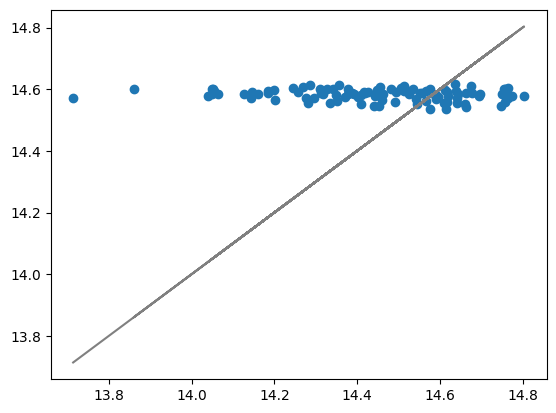

In [68]:
plt.scatter(test_masses[:100, 0, :], gnn_no_edges_masses_pred[:100, 0, :])
plt.plot(test_masses[:100, 0, :], test_masses[:100, 0, :], c='gray')

### Loss convergence

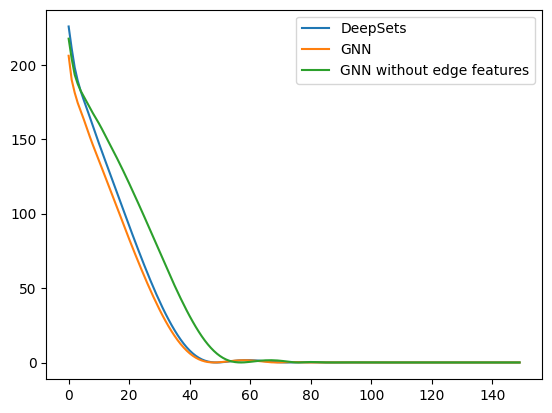

In [51]:
plt.plot(deepsets_losses, label='DeepSets')
plt.plot(gnn_losses, label='GNN')
plt.plot(gnn_no_edges_losses, label='GNN without edge features')
# plt.yscale('log')
plt.legend()

### Notes:
All 3 models predict the average! Still not over-fitting

## Global parameter prediction

### DeepSets

In [105]:
k = 10
n_batch = 10

model_params = {
    'latent_size': 8, 
    'hidden_size': 64, 
    'num_mlp_layers':2, 
    'message_passing_steps':3, 
    'skip_connections': False, 
    'norm':"layer",
    'pooling':"mean",
    'model_type':"deepsets",
    'task':'graph'
}


deepsets_train_loss, deepsets_test_loss, deepsets_omega_m_pred, deepsets_losses = run_global_expt(k, model_params, n_batch=n_batch, n_steps=1500, learning_rate=1e-5)
print('Train loss: {}, Test loss: {}'.format(deepsets_train_loss, deepsets_test_loss))

100%|██████████| 1500/1500 [04:24<00:00,  5.66it/s, loss=0.01825968]  


Train loss: 0.018259679898619652, Test loss: 0.015762148424983025


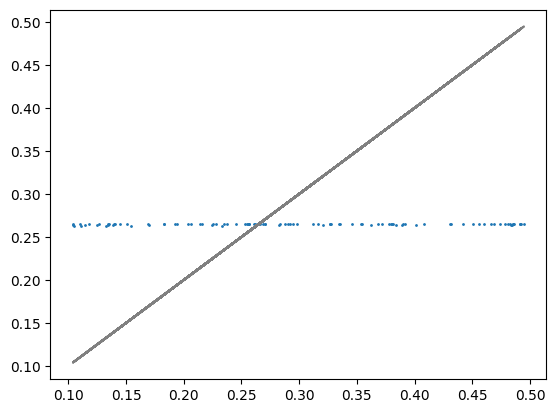

In [106]:
plt.scatter(test_omega_m[:100], deepsets_omega_m_pred[:100,0], s=1)
plt.plot(test_omega_m[:100], test_omega_m[:100], color='gray')

### GNN

In [ ]:
model_params['model_type'] = 'gnn'

gnn_train_loss, gnn_test_loss, gnn_omega_m_pred, gnn_losses = run_global_expt(k, model_params, n_batch=n_batch, n_steps=1500, learning_rate=1e-4)
print('Train loss: {}, Test loss: {}'.format(gnn_train_loss, gnn_test_loss))

 23%|██▎       | 344/1500 [01:14<04:00,  4.82it/s, loss=0.00928362]  

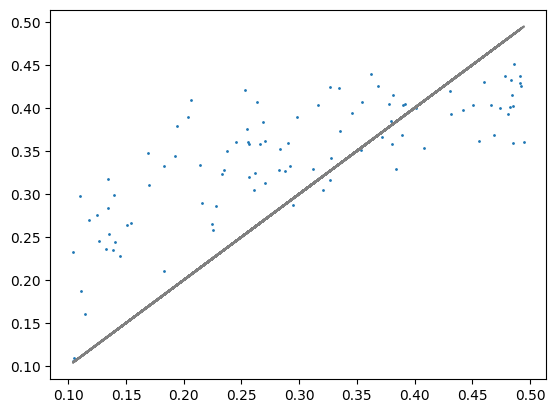

In [78]:
plt.scatter(test_omega_m[:100], gnn_omega_m_pred[:100,0], s=1)
plt.plot(test_omega_m[:100], test_omega_m[:100], color='gray')

 ### GNN without edge features

In [79]:
gnn_no_edges_train_loss, gnn_no_edges_test_loss, gnn_no_edges_omega_m_pred, gnn_no_edges_losses = run_global_expt(k, model_params, n_batch=n_batch, n_overfit=10, n_steps=1500, learning_rate=1e-4, use_edges=False)
print('Train loss: {}, Test loss: {}'.format(gnn_no_edges_train_loss, gnn_no_edges_test_loss))

100%|██████████| 1500/1500 [05:01<00:00,  4.98it/s, loss=3.5298905e-05] 


Train loss: 3.5298904549563304e-05, Test loss: 0.0057013253681361675


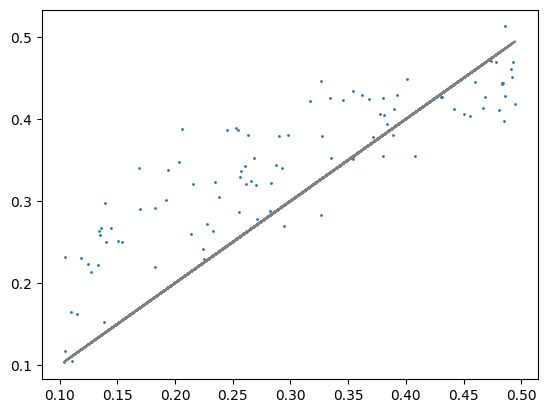

In [80]:
plt.scatter(test_omega_m[:100], gnn_no_edges_omega_m_pred[:100,0], s=1)
plt.plot(test_omega_m[:100], test_omega_m[:100], color='gray')

# Overfitting

## Node-wise prediction

### DeepSets

In [83]:
k = 10
n_batch = 10

model_params = {
    'latent_size': 8, 
    'hidden_size': 64, 
    'num_mlp_layers':2, 
    'message_passing_steps':3, 
    'skip_connections': False, 
    'norm':"layer",
    'pooling':"mean",
    'model_type':"deepsets",
    'task':'node'
}


deepsets_train_loss, deepsets_test_loss, deepsets_masses_pred, deepsets_losses = run_node_expt(k, model_params, n_batch=n_batch, n_overfit=10, n_steps=150, learning_rate=1e-3)
print('Train loss: {}, Test loss: {}'.format(deepsets_train_loss, deepsets_test_loss))

100%|██████████| 150/150 [00:28<00:00,  5.34it/s, loss=0.07508928] 


Train loss: 0.07508928328752518, Test loss: 0.07509230077266693


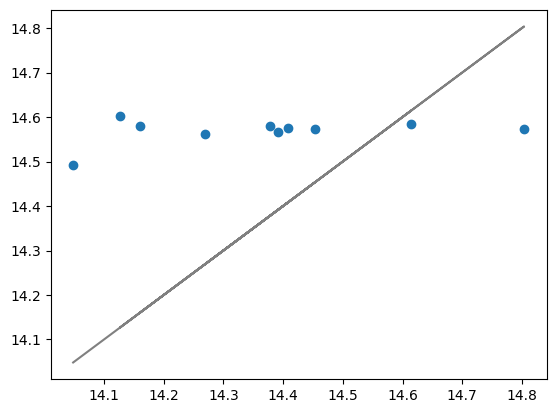

In [85]:
plt.scatter(train_masses[:10, 0, :], deepsets_masses_pred[:10, 0, :])
plt.plot(train_masses[:10, 0, :], train_masses[:10, 0, :], c='gray')

### GNN 

In [86]:
model_params['model_type'] = 'gnn'

gnn_train_loss, gnn_test_loss, gnn_masses_pred, gnn_losses = run_node_expt(k, model_params, n_batch=n_batch, n_overfit=10, n_steps=150, learning_rate=1e-3)
print('Train loss: {}, Test loss: {}'.format(gnn_train_loss, gnn_test_loss))

100%|██████████| 150/150 [00:33<00:00,  4.41it/s, loss=0.07541624] 


Train loss: 0.07541623711585999, Test loss: 0.07542704790830612


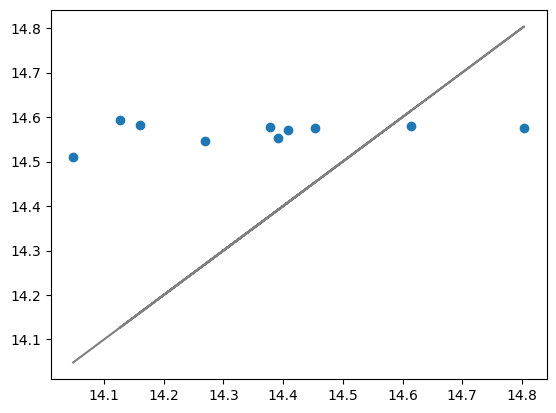

In [87]:
plt.scatter(train_masses[:10, 0, :], gnn_masses_pred[:10, 0, :])
plt.plot(train_masses[:10, 0, :], train_masses[:10, 0, :], c='gray')

### GNN without edge features

In [88]:
gnn_no_edges_train_loss, gnn_no_edges_test_loss, gnn_no_edges_masses_pred, gnn_no_edges_losses = run_node_expt(k, model_params, n_batch=n_batch, n_overfit=10, n_steps=150, learning_rate=1e-3, use_edges=False)
print('Train loss: {}, Test loss: {}'.format(gnn_no_edges_train_loss, gnn_no_edges_test_loss))

100%|██████████| 150/150 [00:32<00:00,  4.68it/s, loss=0.07548229] 


Train loss: 0.07548228651285172, Test loss: 0.07550596445798874


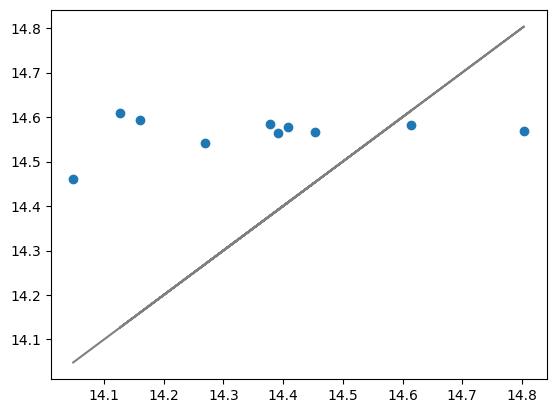

In [89]:
plt.scatter(train_masses[:10, 0, :], gnn_no_edges_masses_pred[:10, 0, :])
plt.plot(train_masses[:10, 0, :], train_masses[:10, 0, :], c='gray')

### Loss convergence

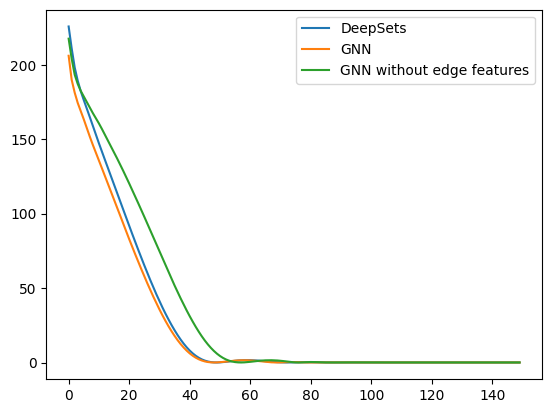

In [90]:
plt.plot(deepsets_losses, label='DeepSets')
plt.plot(gnn_losses, label='GNN')
plt.plot(gnn_no_edges_losses, label='GNN without edge features')
# plt.yscale('log')
plt.legend()

### Notes:
All 3 models predict the average! Still not over-fitting

## Global parameter prediction

In [ ]:
k = 10
n_batch = 10

model_params = {
    'latent_size': 8, 
    'hidden_size': 64, 
    'num_mlp_layers':2, 
    'message_passing_steps':3, 
    'skip_connections': False, 
    'norm':"layer",
    'pooling':"mean",
    'model_type':"deepsets",
    'task':'graph'
}


deepsets_train_loss, deepsets_test_loss, deepsets_omega_m_pred, deepsets_losses, deepsets_embeddings = run_global_expt(k, model_params, n_batch=n_batch, n_overfit=10, n_steps=2, learning_rate=1e-4)
print('Train loss: {}, Test loss: {}'.format(deepsets_train_loss, deepsets_test_loss))

  0%|          | 0/2 [00:00<?, ?it/s]

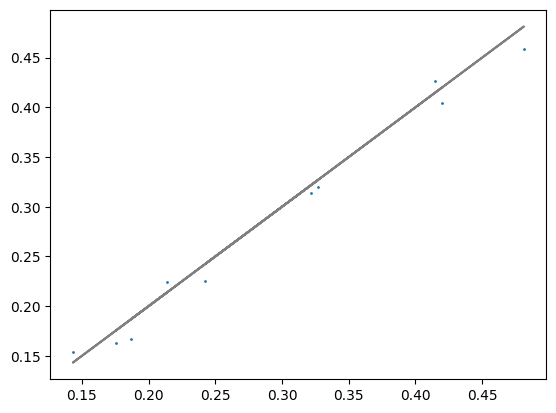

In [93]:
plt.scatter(train_omega_m[:10], deepsets_omega_m_pred[:10,0])
plt.plot(train_omega_m[:10], train_omega_m[:10], color='gray')

In [94]:
model_params['model_type'] = 'gnn'

gnn_train_loss, gnn_test_loss, gnn_omega_m_pred, gnn_losses = run_global_expt(k, model_params, n_batch=n_batch, n_overfit=10, n_steps=1500, learning_rate=1e-4)
print('Train loss: {}, Test loss: {}'.format(gnn_train_loss, gnn_test_loss))

100%|██████████| 1500/1500 [05:17<00:00,  4.73it/s, loss=1.9971486e-08] 


Train loss: 1.9971485798464528e-08, Test loss: 3.618921695647259e-08


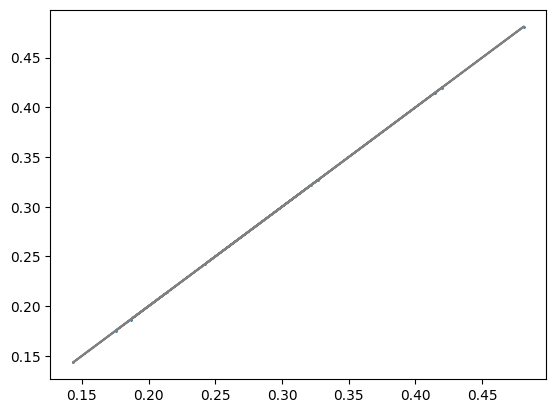

In [95]:
plt.scatter(train_omega_m[:10], gnn_omega_m_pred[:10,0])
plt.plot(train_omega_m[:10], train_omega_m[:10], color='gray')

In [ ]:
gnn_no_edges_train_loss, gnn_test_loss, gnn_no_edges_omega_m_pred, gnn_no_edges_losses = run_global_expt(k, model_params, n_batch=n_batch, n_overfit=10, n_steps=1500, learning_rate=1e-4, use_edges=False)
print('Train loss: {}, Test loss: {}'.format(gnn_no_edges_train_loss, gnn_no_edges_test_loss))

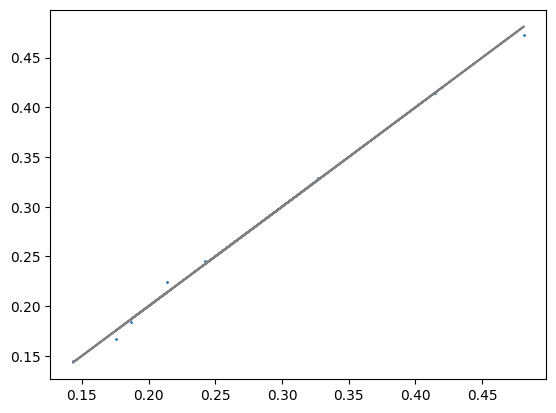

In [97]:
plt.scatter(train_omega_m[:10], gnn_no_edges_omega_m_pred[:10,0])
plt.plot(train_omega_m[:10], train_omega_m[:10], color='gray')

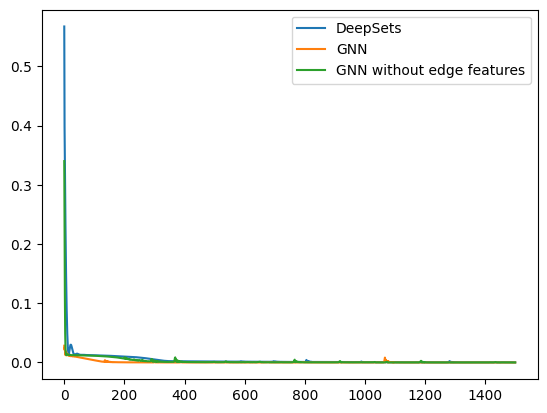

In [100]:
plt.plot(deepsets_losses, label='DeepSets')
plt.plot(gnn_losses, label='GNN')
plt.plot(gnn_no_edges_losses, label='GNN without edge features')
# plt.yscale('log')
plt.legend()

* check whether there is enough information in the neighborhood of each galaxy for nodewise prediction
* smaller sample of each simulation
* check dynamic range
